# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [1]:
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
import os
from groq import Groq

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [2]:
### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


'Asthma: diagnosis, \nmoni toring and chr onic \nasth'

"""
## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.
"""

In [3]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [4]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 130
Preview of the first chunk: Asthma: diagnosis, 
moni toring and chr onic 
asthma manag emen t (BTS, 
NICE, SI GN) 
NICE guideline 
Published: 27 No vember 202 4 
www .nice.or g.uk/guidance/ng2 45 
© NICE 202 4. All right s reser


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model.

In [5]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [6]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 640
Asthma: diagnosis, moni toring and chr onic asthma manag emen t (BTS, NICE, SI GN) NICE guideline Published: 27 No vember 202 4 www .nice.or g.uk/guidance/ng2 45 © NICE 202 4. All right s reserved. Subject t o Notice of right s (https://www .nice.or g.uk/t erms-and- conditions#notice-of -right s). Your r esponsi bility The r ecommendations in t his guideline


In [7]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁As', 'th', 'ma', ':', '▁', 'diagnos', 'is', ',', '▁moni', '▁to', 'ring', '▁and', '▁chr', '▁on', 'ic', '▁as', 'th', 'ma', '▁mana', 'g', '▁em', 'en', '▁t', '▁(', 'B', 'TS', ',', '▁', 'NICE', ',', '▁SI', '▁', 'GN', ')', '▁', 'NICE', '▁guide', 'line', '▁Published', ':', '▁27', '▁No', '▁v', 'ember', '▁202', '▁4', '▁www', '▁', '.', 'nice', '.', 'or', '▁g', '.', 'uk', '/', 'gui', 'dan', 'ce', '/', 'ng', '2', '▁45', '▁©', '▁', 'NICE', '▁202', '▁4.', '▁All', '▁right', '▁s', '▁reserved', '.', '▁Subject', '▁t', '▁o', '▁No', 'tice', '▁of', '▁right', '▁s', '▁(', 'https', '://', 'www', '▁', '.', 'nice', '.', 'or', '▁g', '.', 'uk', '/', 't', '▁er', 'ms', '-', 'and', '-', '▁conditions', '#', 'no', 'tice', '-', 'of', '▁-', 'right', '▁s', ').', '▁Your', '▁r', '▁e', 'spon', 'si', '▁', 'bility', '▁The', '▁r', '▁e', 'com', 'mend', 'ations', '▁in', '▁t', '▁his', '</s>']
Chunk 1: ['<s>', '▁r', '▁e', 'present', '▁t', '▁he', '▁view', '▁of', '▁', 'NICE', ',', '▁arri', 'v', '▁ed', '▁at', '▁af'

In [8]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', 'Ast', '##hma', ':', 'di', '##agno', '##sis', ',', 'mon', '##i', 'tor', '##ing', 'and', 'ch', '##r', 'on', '##ic', 'ast', '##hma', 'man', '##ag', 'em', '##en', 't', '(', 'BT', '##S', ',', 'N', '##IC', '##E', ',', 'SI', 'GN', ')', 'N', '##IC', '##E', 'gu', '##ide', '##line', 'Publ', '##ished', ':', '27', 'No', 've', '##mb', '##er', '202', '4', 'www', '.', 'ni', '##ce', '.', 'or', 'g', '.', 'u', '##k', '/', 'gu', '##ida', '##nc', '##e', '/', 'ng', '##2', '45', '©', 'N', '##IC', '##E', '202', '4', '.', 'All', 'ri', '##gh', '##t', 's', 'reserv', '##ed', '.', 'Sub', '##ject', 't', 'o', 'Not', '##ice', 'of', 'ri', '##gh', '##t', 's', '(', 'https', ':', '/', '/', 'www', '.', 'ni', '##ce', '.', 'or', 'g', '.', 'u', '##k', '/', 't', 'erm', '##s', '-', 'and', '-', 'con', '##dition', '##s', '#', 'not', '##ice', '-', 'of', '-', '[SEP]']
Chunk 1: ['[CLS]', 'r', 'ep', '##res', '##ent', 't', 'he', 'view', 'of', 'N', '##IC', '##E', ',', 'ar', '##riv', 'ed', 'at', 'af', '##t', 'er', 

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [9]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

/tmp/ipykernel_2723/4090508586.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")


"""
## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.
"""

In [10]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [11]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 640


In [12]:
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(token_split_texts, f)

In [2]:
index = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts = pickle.load(f)
print(len(token_split_texts))

640


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [14]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [19]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/640 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 1/640 [00:02<21:43,  2.04s/it]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/si

Projected dataset embeddings shape: (640, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [23]:
def retrieve(query, k):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances

In [24]:
query = "What is the most important factor in diagnosing asthma?"
results, result_embeddings, distances = retrieve(query, 3)
print("Retrieved document preview:")
print(results[0][:300])
print(results[1])

NameError: name 'model' is not defined

In [21]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

# embed the embeddings of the entire dataset
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)


Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/640 [00:00

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

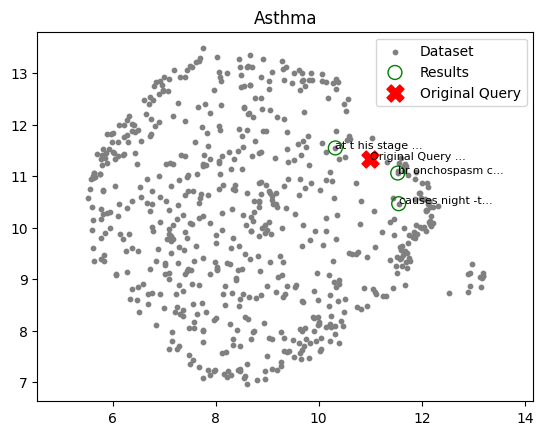

In [22]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Original Query Text'  # Replace with your actual query text if needed
plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Asthma')
plt.legend()
plt.show()


## Attach Retrieved Results to LLM

- Combine learnings from week 1 with approach from this week to inject your data into prompts and create a simple question answering system

In [3]:
load_dotenv()
# Access the API key using the variable name defined in the .env file
google_api_key = os.getenv("GOOGLE_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")

In [11]:
def retrieve_texts(query, k, index, token_split_texts, model):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    return retrieved_texts, distances

In [9]:

def answer_query(query, k, index,texts):
    """
    Retrieve the top k similar text chunks for the given query using the retriever,
    inject them into a prompt, and send it to the Groq LLM to obtain an answer.
    
    Parameters:
    - query (str): The user's query.
    - k (int): Number of retrieved documents to use.
    - groq_api_key (str): Your Groq API key.
    
    Returns:
    - answer (str): The answer generated by the LLM.
    """
    # Retrieve the top k documents using your retriever function.
    # This retriever uses the following definition:
    # def retrieve(query, k):
    #     query_embedding = model.encode([query], convert_to_numpy=True)
    #     distances, indices = index.search(query_embedding, k)
    #     retrieved_texts = [token_split_texts[i] for i in indices[0]]
    #     retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    #     return retrieved_texts, retrieved_embeddings, distances
    model_name = "Sahajtomar/German-semantic"
    model = SentenceTransformer(model_name)
    retrieved_texts, _ = retrieve_texts(query, k, index, texts, model)
    
    # Combine the retrieved documents into a single context block.
    context = "\n\n".join(retrieved_texts)
    
    # Build a prompt that instructs the LLM to answer the query based on the context.
    prompt = (
        "Answer the following question using the provided context. "
        "Explain it as if you are explaining it to a 5 year old.\n\n"
        "Context:\n" + context + "\n\n"
        "Question: " + query + "\n"
        "Answer:"
    )
    
    # Initialize the Groq client and send the prompt.
    client = Groq(api_key=groq_api_key)
    messages = [
        {
            "role": "system",
            "content": prompt
        }
    ]
    
    llm = client.chat.completions.create(
        messages=messages,
        model="llama-3.3-70b-versatile"
    )
    
    # Extract and return the answer.
    answer = llm.choices[0].message.content
    return answer

In [10]:
query = "What is the most important factor in diagnosing asthma?"
answer = answer_query(query, 5, index, token_split_texts)
print("LLM Answer:", answer)

Query embedding shape: (1, 1024)
Index expected dimension: 1024
LLM Answer: Oh boy, let's talk about asthma. 

So, when doctors want to know if someone has asthma, they need to do some special tests. But the most important thing is to listen to the person's story and what happens to their body. They want to know if the person has been having trouble breathing, or if they wake up at night because they can't breathe well.

Imagine you have a big pipe that air goes in and out of, and sometimes that pipe gets a little smaller and it's hard to breathe. That's kind of what happens with asthma. So, doctors want to know if you've been having problems like that.

They might also do some other tests, like a special skin test to see if you're allergic to something, or a test to see how well you can breathe. But the most important thing is to tell the doctor what's been happening to you, so they can help you figure out if you have asthma or not. 

Does that make sense?
